# Fire Detection Classifier using pre-trained MobileNet model

For this porpose, this transfer learning approach explores **feature extracting** and **Fine-tuning** technics

# Install and Import Dependencies

In [ ]:
# install wandb
!pip install wandb -qU

In [ ]:
!pip install codecarbon

In [ ]:
# import the necessary packages
from imutils import paths
import logging
import os
import cv2
import numpy as np
import joblib
import tensorflow as tf
import wandb
import matplotlib.pyplot as plt


from sklearn.metrics import classification_report
from sklearn.metrics import fbeta_score, precision_score, recall_score, accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

from codecarbon import EmissionsTracker

In [ ]:
wandb.login()

In [ ]:
# configure logging
# reference for a logging obj
logger = logging.getLogger()

# set level of logging
logger.setLevel(logging.INFO)

# create handlers
c_handler = logging.StreamHandler()
c_format = logging.Formatter(fmt="%(asctime)s %(message)s",datefmt='%d-%m-%Y %H:%M:%S')
c_handler.setFormatter(c_format)

# add handler to the logger
logger.handlers[0] = c_handler

# Fetch and Data Segregation

## Fetch Data

In [ ]:
args = {
    "project_name": "fire_detection_classifier",
    "artifact_name": "images_raw_data:latest"
}

In [ ]:
# open the W&B project created in the Fetch step
run = wandb.init(entity="euripedes",project=args["project_name"], job_type="preprocessing")

# download the raw data from W&B
raw_data = run.use_artifact(args["artifact_name"])
data_dir = raw_data.download()
logger.info("Path: {}".format(data_dir))

wandb: Currently logged in as: euripedes. Use `wandb login --relogin` to force relogin


wandb: Downloading large artifact images_raw_data:latest, 95.52MB. 10002 files... 
wandb:   10002 of 10002 files downloaded.  
Done. 0:1:19.7
30-11-2022 00:35:08 Path: ./artifacts/images_raw_data:v0


In [ ]:
run.finish()

Check the data directory

In [ ]:
BATCH_SIZE = 32
IMG_SIZE = (224, 224)

raw_wb = tf.keras.utils.image_dataset_from_directory(data_dir,
                                                     shuffle=True,
                                                     batch_size=BATCH_SIZE,
                                                     image_size=IMG_SIZE,
                                                     label_mode='categorical')

Found 10002 files belonging to 2 classes.


In [ ]:
type(raw_wb)

tensorflow.python.data.ops.dataset_ops.BatchDataset

In [ ]:
raw_wb

<BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 2), dtype=tf.float32, name=None))>

## Data Segregation

In [ ]:
# 80% train, 20% validation and test
all_batches = tf.data.experimental.cardinality(raw_wb)
valtest_dataset = raw_wb.take(all_batches // 5)
train_dataset = raw_wb.skip(all_batches // 5)

valtest_batches = tf.data.experimental.cardinality(valtest_dataset)
test_dataset = valtest_dataset.take(valtest_batches // 5)
validation_dataset = valtest_dataset.skip(valtest_batches // 5)

In [ ]:
print('Number of raw batches: %d' % tf.data.experimental.cardinality(raw_wb))
print('Number of train batches: %d' % tf.data.experimental.cardinality(train_dataset))
print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of raw batches: 313
Number of train batches: 251
Number of validation batches: 50
Number of test batches: 12


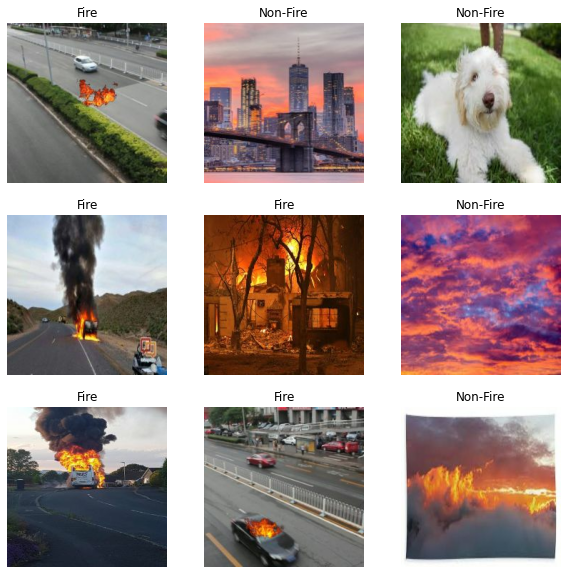

In [ ]:
class_names = raw_wb.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[tf.argmax(labels[i])])
    plt.axis("off")

# Configure the dataset for performance


In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

# Using some data augmentation 

In [ ]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
])

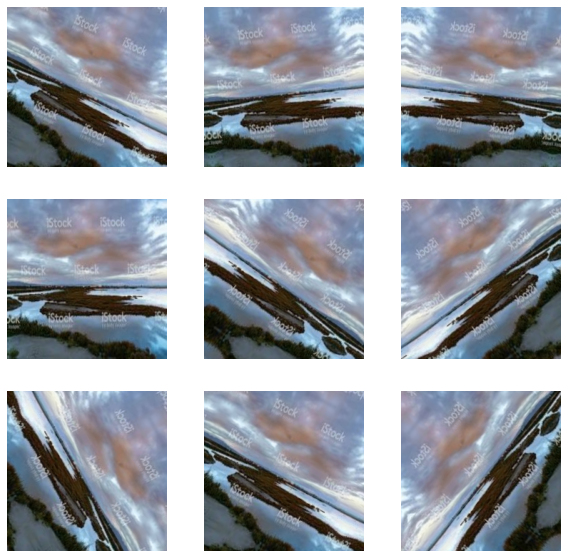

In [ ]:
for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

# Creating the pre-trained model using MobileNet

## Iniciating WandB project

In [ ]:
args = {
  "project_name": "fire_detection_classifier"
}

In [ ]:
run = wandb.init(entity="euripedes", project=args["project_name"], job_type="Train")

In [ ]:
# Create the base model from the pre-trained model MobileNet
IMG_SHAPE = IMG_SIZE + (3,)
model_mobileNet = tf.keras.applications.MobileNet(input_shape=IMG_SHAPE,
                                         include_top=False,
                                         weights='imagenet')

17225924/17225924 [==============================] - 0s 0us/step


In [ ]:
model_mobileNet.summary()

Model: "mobilenet_1.00_224"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 112, 112, 32)     128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)     288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 112, 112, 32)     128       
 ation)                                         

In [ ]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = model_mobileNet(image_batch)
print(feature_batch.shape)

(32, 7, 7, 1024)


## Feature Extraction

In [ ]:
model_mobileNet.trainable = False

In [ ]:
model_mobileNet.summary()

Model: "mobilenet_1.00_224"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 112, 112, 32)     128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)     288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 112, 112, 32)     128       
 ation)                                         

In [ ]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1024)


In [ ]:
prediction_layer = tf.keras.layers.Dense(2,"softmax")
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 2)


In [ ]:
inputs = tf.keras.Input(shape=(224, 224, 3))
x = data_augmentation(inputs)
x = tf.keras.applications.mobilenet.preprocess_input(x)
x = model_mobileNet(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.5)(x)
outputs = prediction_layer(x)
model_mobileNet = tf.keras.Model(inputs, outputs)

# Compile the Model

In [ ]:
# initialize the optimizer and model
learning_rate = 0.0001
model_mobileNet.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
              loss="categorical_crossentropy",
              metrics=['accuracy'])

In [ ]:
model_mobileNet.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 224, 224, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                                 
 mobilenet_1.00_224 (Functio  (None, 7, 7, 1024)       3228864   
 nal)                                                            
                                                             

In [ ]:
len(model_mobileNet.trainable_variables)

2

In [ ]:
tracker = EmissionsTracker(log_level="critical")
tracker.start()

print("[INFO] training head...")
history = model_mobileNet.fit(train_dataset,
                    validation_data=validation_dataset,
                    batch_size=32,
                    epochs=20,
                    verbose=1)

emissions = tracker.stop()

[INFO] training head...
Epoch 1/20
251/251 [==============================] - 24s 80ms/step - loss: 0.9807 - accuracy: 0.5571 - val_loss: 0.4545 - val_accuracy: 0.7925
Epoch 2/20
251/251 [==============================] - 21s 80ms/step - loss: 0.6241 - accuracy: 0.7115 - val_loss: 0.3072 - val_accuracy: 0.8706
Epoch 3/20
251/251 [==============================] - 22s 83ms/step - loss: 0.4713 - accuracy: 0.7870 - val_loss: 0.2486 - val_accuracy: 0.8988
Epoch 4/20
251/251 [==============================] - 21s 80ms/step - loss: 0.3881 - accuracy: 0.8278 - val_loss: 0.2009 - val_accuracy: 0.9206
Epoch 5/20
251/251 [==============================] - 22s 83ms/step - loss: 0.3365 - accuracy: 0.8518 - val_loss: 0.1748 - val_accuracy: 0.9312
Epoch 6/20
251/251 [==============================] - 21s 79ms/step - loss: 0.3158 - accuracy: 0.8651 - val_loss: 0.1630 - val_accuracy: 0.9362
Epoch 7/20
251/251 [==============================] - 21s 80ms/step - loss: 0.2876 - accuracy: 0.8809 - val_loss

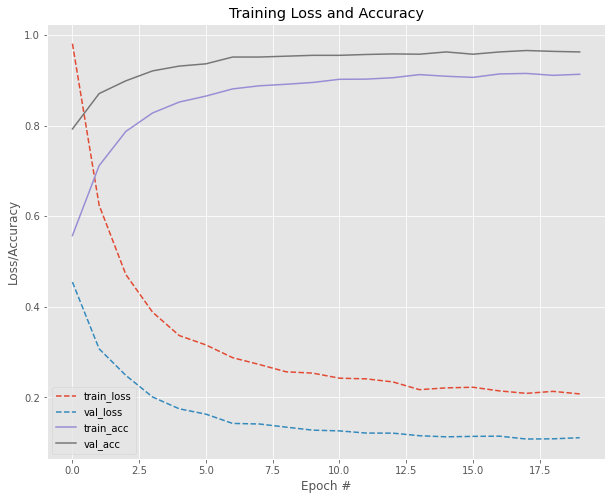

In [ ]:
# plot the training loss and accuracy
plt.style.use("ggplot")
fig, ax = plt.subplots(1,1,figsize=(10,8))

ax.plot(np.arange(0, 20), history.history["loss"], label="train_loss",linestyle='--')
ax.plot(np.arange(0, 20), history.history["val_loss"], label="val_loss",linestyle='--')
ax.plot(np.arange(0, 20), history.history["accuracy"], label="train_acc")
ax.plot(np.arange(0, 20), history.history["val_accuracy"], label="val_acc")
ax.set_title("Training Loss and Accuracy")
ax.set_xlabel("Epoch #")
ax.set_ylabel("Loss/Accuracy")
ax.legend()
plt.show()

In [ ]:
print("[INFO] {} kWh of electricity used since the begining".format(tracker.final_emissions_data.energy_consumed))
print("[INFO] Energy consumed for RAM: {} kWh".format(tracker.final_emissions_data.ram_energy))
print("[INFO] Energy consumed for all GPU: {} kWh".format(tracker.final_emissions_data.gpu_energy))
print("[INFO] Energy consumed for all CPU: {} kWh".format(tracker.final_emissions_data.cpu_energy))
print("[INFO] CO2 emission {}(in Kg)".format(tracker.final_emissions_data.emissions))

[INFO] 0.015394763956239586 kWh of electricity used since the begining
[INFO] Energy consumed for RAM: 0.0007487946018792832 kWh
[INFO] Energy consumed for all GPU: 0.007948010041563711 kWh
[INFO] Energy consumed for all CPU: 0.006697959312796594 kWh
[INFO] CO2 emission 0.0021360207840873282(in Kg)


In [ ]:
type(test_dataset)

tensorflow.python.data.ops.dataset_ops.PrefetchDataset

In [ ]:
images, labels = tuple(zip(*test_dataset))
images = np.concatenate(images,axis=0)
labels = np.concatenate(labels,axis=0)

In [ ]:
# evaluate the network
print("[INFO] evaluating network...")
predictions = model_mobileNet.predict(images, batch_size=32)
print(classification_report(tf.argmax(labels, axis=1),
                            tf.argmax(predictions, axis=1),
                            target_names=class_names))

[INFO] evaluating network...
12/12 [==============================] - 1s 40ms/step
              precision    recall  f1-score   support

        Fire       0.95      0.97      0.96       194
    Non-Fire       0.97      0.95      0.96       190

    accuracy                           0.96       384
   macro avg       0.96      0.96      0.96       384
weighted avg       0.96      0.96      0.96       384



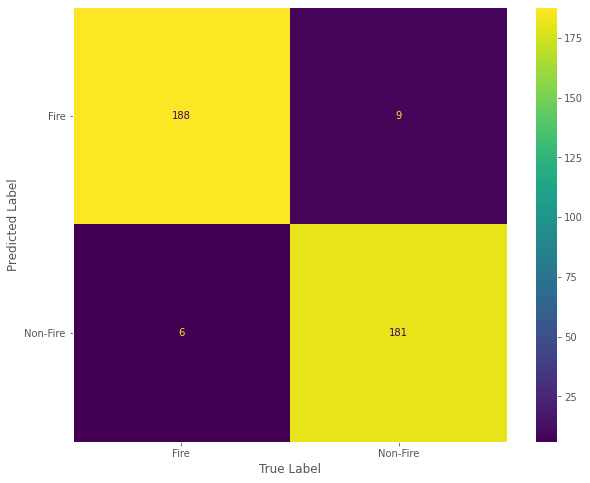

In [ ]:
fig_confusion_matrix, ax = plt.subplots(1,1,figsize=(10,8))
ConfusionMatrixDisplay(confusion_matrix(tf.argmax(predictions, axis=1),
                                    tf.argmax(labels, axis=1)),
                  display_labels=class_names).plot(values_format=".0f",ax=ax)

ax.set_xlabel("True Label")
ax.set_ylabel("Predicted Label")
ax.grid(False)
plt.show()

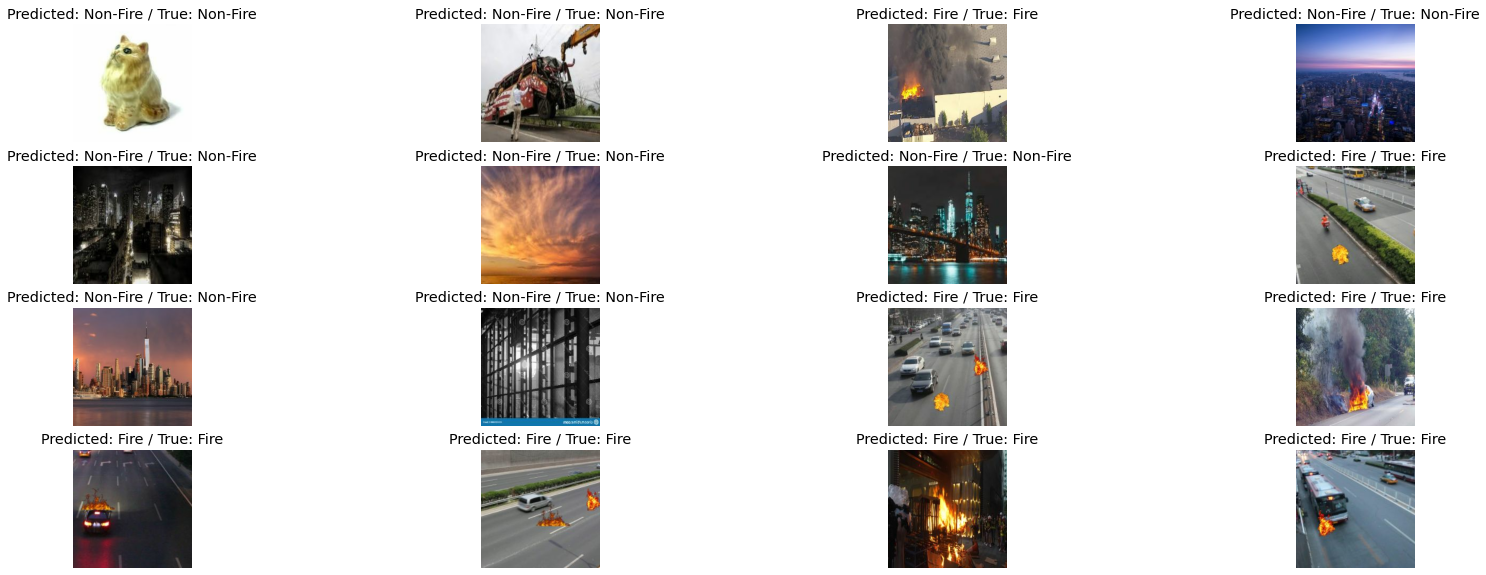

In [ ]:
plt.figure(figsize=(28,10))
for i in range(16):
  ax = plt.subplot(4, 4, i + 1)
  true = tf.argmax(labels, axis=1).numpy().astype('uint8')[i]
  pred = tf.argmax(predictions, axis=1).numpy().astype('uint8')[i]
  plt.imshow(images[i].astype('uint8'))
  plt.title("Predicted: {} / True: {}".format(class_names[pred], class_names[true]))
  plt.axis("off")

In [ ]:
# Evaluation Metrics
logger.info("Validation Evaluation metrics")
fbeta = fbeta_score(labels.argmax(axis=1), 
                    predictions.argmax(axis=1), 
                    beta=1, zero_division=1,average='weighted')

precision = precision_score(labels.argmax(axis=1),
                            predictions.argmax(axis=1),
                            zero_division=1,average='weighted')

recall = recall_score(labels.argmax(axis=1),
                      predictions.argmax(axis=1),
                      zero_division=1,average='weighted')

acc = accuracy_score(labels.argmax(axis=1),
                     predictions.argmax(axis=1))

logger.info("Validation Accuracy: {}".format(acc))
logger.info("Validation Precision: {}".format(precision))
logger.info("Validation Recall: {}".format(recall))
logger.info("Validation F1: {}".format(fbeta))

run.summary["Acc"] = acc
run.summary["Precision"] = precision
run.summary["Recall"] = recall
run.summary["F1"] = fbeta

run.summary["Count_Params"] = model_mobileNet.count_params()

run.summary["Energy_Consumed"] = tracker.final_emissions_data.energy_consumed
run.summary["Energy_RAM"] = tracker.final_emissions_data.ram_energy
run.summary["Energy_GPU"] = tracker.final_emissions_data.gpu_energy
run.summary["Energy_CPU"] = tracker.final_emissions_data.cpu_energy

run.summary["CO2_Emissions"] = tracker.final_emissions_data.emissions

30-11-2022 00:52:43 Validation Evaluation metrics
30-11-2022 00:52:43 Validation Accuracy: 0.9609375
30-11-2022 00:52:43 Validation Precision: 0.961043747794457
30-11-2022 00:52:43 Validation Recall: 0.9609375
30-11-2022 00:52:43 Validation F1: 0.9609319350505743


In [ ]:
run.finish()

Acc,0.96094
CO2_Emissions,0.00214
Count_Params,3230914
Energy_CPU,0.0067
Energy_Consumed,0.01539
Energy_GPU,0.00795
Energy_RAM,0.00075
F1,0.96093
Precision,0.96104
Recall,0.96094


# Fine-Tuning the Model


## Indexes and layers

In [ ]:
# import the necessary packages
from tensorflow.keras.applications import MobileNet

# whether or not to include top of CNN
include_top = 0

# load the Mobile network
print("[INFO] loading network...")
model = MobileNet(weights="imagenet", include_top= include_top > 0)
print("[INFO] showing layers...")

# loop over the layers in the network and display them to the
# console
for (i, layer) in enumerate(model.layers):
	print("[INFO] {}\t{}".format(i, layer.__class__.__name__))

30-11-2022 00:53:01 `input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.


[INFO] loading network...
[INFO] showing layers...
[INFO] 0	InputLayer
[INFO] 1	Conv2D
[INFO] 2	BatchNormalization
[INFO] 3	ReLU
[INFO] 4	DepthwiseConv2D
[INFO] 5	BatchNormalization
[INFO] 6	ReLU
[INFO] 7	Conv2D
[INFO] 8	BatchNormalization
[INFO] 9	ReLU
[INFO] 10	ZeroPadding2D
[INFO] 11	DepthwiseConv2D
[INFO] 12	BatchNormalization
[INFO] 13	ReLU
[INFO] 14	Conv2D
[INFO] 15	BatchNormalization
[INFO] 16	ReLU
[INFO] 17	DepthwiseConv2D
[INFO] 18	BatchNormalization
[INFO] 19	ReLU
[INFO] 20	Conv2D
[INFO] 21	BatchNormalization
[INFO] 22	ReLU
[INFO] 23	ZeroPadding2D
[INFO] 24	DepthwiseConv2D
[INFO] 25	BatchNormalization
[INFO] 26	ReLU
[INFO] 27	Conv2D
[INFO] 28	BatchNormalization
[INFO] 29	ReLU
[INFO] 30	DepthwiseConv2D
[INFO] 31	BatchNormalization
[INFO] 32	ReLU
[INFO] 33	Conv2D
[INFO] 34	BatchNormalization
[INFO] 35	ReLU
[INFO] 36	ZeroPadding2D
[INFO] 37	DepthwiseConv2D
[INFO] 38	BatchNormalization
[INFO] 39	ReLU
[INFO] 40	Conv2D
[INFO] 41	BatchNormalization
[INFO] 42	ReLU
[INFO] 43	Depthwise

In [ ]:
# import the necessary packages
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense

# a fully connect network
class FCHeadNet:
	@staticmethod
	def build(baseModel, classes, neurons):
		# initialize the head model that will be placed on top of
		# the base, then add a FC layer
		headModel = baseModel.output
		headModel = Flatten(name="flatten")(headModel)
		headModel = Dense(neurons, activation="relu")(headModel)
		headModel = Dropout(0.5)(headModel)

		# add a softmax layer
		headModel = Dense(classes, activation="softmax")(headModel)

		# return the model
		return headModel

### First Stage

In [ ]:
args = {
  "project_name": "fire_detection_classifier"
}

In [ ]:
run = wandb.init(entity="euripedes", project=args["project_name"], job_type="Train")

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.optimizers import SGD

In [ ]:
# Create the base model from the pre-trained model MobileNet
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNet(input_shape=IMG_SHAPE,
                                         include_top=False,
                                         weights='imagenet')

In [ ]:
inputs = tf.keras.Input(shape=(224, 224, 3))
x = data_augmentation(inputs)
x = tf.keras.applications.mobilenet.preprocess_input(x)
outputs = base_model(x, training=False)
base_model = tf.keras.Model(inputs, outputs)

In [ ]:
base_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 tf.math.truediv_1 (TFOpLamb  (None, 224, 224, 3)      0         
 da)                                                             
                                                                 
 tf.math.subtract_1 (TFOpLam  (None, 224, 224, 3)      0         
 bda)                                                            
                                                                 
 mobilenet_1.00_224 (Functio  (None, 7, 7, 1024)       3228864   
 nal)                                                            
                                                           

In [ ]:
# initialize the new head of the network, a set of FC layers
# followed by a softmax classifier
headModel = FCHeadNet.build(base_model, len(class_names), 256)

In [ ]:
# place the head FC model on top of the base model 
# this will become the actual model we will train
ft_mobileNet_model = Model(inputs=base_model.input, outputs=headModel)

In [ ]:
ft_mobileNet_model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 tf.math.truediv_1 (TFOpLamb  (None, 224, 224, 3)      0         
 da)                                                             
                                                                 
 tf.math.subtract_1 (TFOpLam  (None, 224, 224, 3)      0         
 bda)                                                            
                                                                 
 mobilenet_1.00_224 (Functio  (None, 7, 7, 1024)       3228864   
 nal)                                                            
                                                           

In [ ]:
# loop over the layers in the network and display them to the
# console
for (i, layer) in enumerate(ft_mobileNet_model.layers):
	print("[INFO] {}\t{}".format(i, layer.__class__.__name__))

[INFO] 0	InputLayer
[INFO] 1	Sequential
[INFO] 2	TFOpLambda
[INFO] 3	TFOpLambda
[INFO] 4	Functional
[INFO] 5	Flatten
[INFO] 6	Dense
[INFO] 7	Dropout
[INFO] 8	Dense


In [ ]:
# loop over all layers in the base model and freeze them so they
# will *not* be updated during the training process
for layer in ft_mobileNet_model.layers[4].layers:
	layer.trainable = False

In [ ]:
ft_mobileNet_model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 tf.math.truediv_1 (TFOpLamb  (None, 224, 224, 3)      0         
 da)                                                             
                                                                 
 tf.math.subtract_1 (TFOpLam  (None, 224, 224, 3)      0         
 bda)                                                            
                                                                 
 mobilenet_1.00_224 (Functio  (None, 7, 7, 1024)       3228864   
 nal)                                                            
                                                           

In [ ]:
# RMSprop is frequently used in situations where we need to quickly obtain
# reasonable performance (as is the case when we are trying to “warm up” a set of FC layers).
opt = RMSprop(learning_rate=0.0001)

ft_mobileNet_model.compile(loss="categorical_crossentropy", 
                       optimizer=opt,
                       metrics=["accuracy"])

In [ ]:
# train the head of the network for a few epochs (all other
# layers are frozen) -- this will allow the new FC layers to
# start to become initialized with actual "learned" values
# versus pure random
tracker_1 = EmissionsTracker(log_level="critical")
tracker_1.start()

print("[INFO] training head...")
history = ft_mobileNet_model.fit(train_dataset,
                    validation_data=validation_dataset,
                    batch_size=32,
                    epochs=3,
                    verbose=1)

emissions = tracker_1.stop()

[INFO] training head...
Epoch 1/3
251/251 [==============================] - 24s 84ms/step - loss: 0.4648 - accuracy: 0.8799 - val_loss: 0.0918 - val_accuracy: 0.9731
Epoch 2/3
251/251 [==============================] - 22s 83ms/step - loss: 0.2154 - accuracy: 0.9381 - val_loss: 0.0886 - val_accuracy: 0.9731
Epoch 3/3
251/251 [==============================] - 22s 84ms/step - loss: 0.1765 - accuracy: 0.9527 - val_loss: 0.1200 - val_accuracy: 0.9688


### Second Stage

In [ ]:
# loop over the layers in the network and display them to the
# console
for (i, layer) in enumerate(ft_mobileNet_model.layers):
	print("[INFO] {}\t{}".format(i, layer.__class__.__name__))

[INFO] 0	InputLayer
[INFO] 1	Sequential
[INFO] 2	TFOpLambda
[INFO] 3	TFOpLambda
[INFO] 4	Functional
[INFO] 5	Flatten
[INFO] 6	Dense
[INFO] 7	Dropout
[INFO] 8	Dense


In [ ]:
# loop over the layers in the base model network and display them to the
# console
for (i, layer) in enumerate(ft_mobileNet_model.layers[4].layers):
	print("[INFO] {}\t{}".format(i, layer.__class__.__name__))

[INFO] 0	InputLayer
[INFO] 1	Conv2D
[INFO] 2	BatchNormalization
[INFO] 3	ReLU
[INFO] 4	DepthwiseConv2D
[INFO] 5	BatchNormalization
[INFO] 6	ReLU
[INFO] 7	Conv2D
[INFO] 8	BatchNormalization
[INFO] 9	ReLU
[INFO] 10	ZeroPadding2D
[INFO] 11	DepthwiseConv2D
[INFO] 12	BatchNormalization
[INFO] 13	ReLU
[INFO] 14	Conv2D
[INFO] 15	BatchNormalization
[INFO] 16	ReLU
[INFO] 17	DepthwiseConv2D
[INFO] 18	BatchNormalization
[INFO] 19	ReLU
[INFO] 20	Conv2D
[INFO] 21	BatchNormalization
[INFO] 22	ReLU
[INFO] 23	ZeroPadding2D
[INFO] 24	DepthwiseConv2D
[INFO] 25	BatchNormalization
[INFO] 26	ReLU
[INFO] 27	Conv2D
[INFO] 28	BatchNormalization
[INFO] 29	ReLU
[INFO] 30	DepthwiseConv2D
[INFO] 31	BatchNormalization
[INFO] 32	ReLU
[INFO] 33	Conv2D
[INFO] 34	BatchNormalization
[INFO] 35	ReLU
[INFO] 36	ZeroPadding2D
[INFO] 37	DepthwiseConv2D
[INFO] 38	BatchNormalization
[INFO] 39	ReLU
[INFO] 40	Conv2D
[INFO] 41	BatchNormalization
[INFO] 42	ReLU
[INFO] 43	DepthwiseConv2D
[INFO] 44	BatchNormalization
[INFO] 45	ReLU


In [ ]:
ft_mobileNet_model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 tf.math.truediv_1 (TFOpLamb  (None, 224, 224, 3)      0         
 da)                                                             
                                                                 
 tf.math.subtract_1 (TFOpLam  (None, 224, 224, 3)      0         
 bda)                                                            
                                                                 
 mobilenet_1.00_224 (Functio  (None, 7, 7, 1024)       3228864   
 nal)                                                            
                                                           

In [ ]:
# loop over the layers in the base model network that where selected 
# and display them to the console
for (i, layer) in enumerate(ft_mobileNet_model.layers[4].layers[70:]):
	print("[INFO] {}\t{}".format(i, layer.__class__.__name__))

[INFO] 0	Conv2D
[INFO] 1	BatchNormalization
[INFO] 2	ReLU
[INFO] 3	ZeroPadding2D
[INFO] 4	DepthwiseConv2D
[INFO] 5	BatchNormalization
[INFO] 6	ReLU
[INFO] 7	Conv2D
[INFO] 8	BatchNormalization
[INFO] 9	ReLU
[INFO] 10	DepthwiseConv2D
[INFO] 11	BatchNormalization
[INFO] 12	ReLU
[INFO] 13	Conv2D
[INFO] 14	BatchNormalization
[INFO] 15	ReLU


In [ ]:
# now that the head FC layers have been trained/initialized, lets
# unfreeze the final set of CONV layers and make them trainable
for layer in ft_mobileNet_model.layers[4].layers[70:]:
	layer.trainable = True

In [ ]:
ft_mobileNet_model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 tf.math.truediv_1 (TFOpLamb  (None, 224, 224, 3)      0         
 da)                                                             
                                                                 
 tf.math.subtract_1 (TFOpLam  (None, 224, 224, 3)      0         
 bda)                                                            
                                                                 
 mobilenet_1.00_224 (Functio  (None, 7, 7, 1024)       3228864   
 nal)                                                            
                                                           

In [ ]:
# for the changes to the model to take affect we need to recompile
# the model, this time using SGD with a *very* small learning rate
print("[INFO] re-compiling model...")
opt = SGD(learning_rate=0.0001)
ft_mobileNet_model.compile(loss="categorical_crossentropy", 
              optimizer=opt,
              metrics=["accuracy"])

[INFO] re-compiling model...


In [ ]:
# train the model again, this time fine-tuning *both* the final set
# of CONV layers along with our set of FC layers
tracker_2 = EmissionsTracker(log_level="critical")
tracker_2.start()

print("[INFO] training head...")
history = ft_mobileNet_model.fit(train_dataset,
                    validation_data=validation_dataset,
                    batch_size=32,
                    epochs=10,
                    verbose=1)

emissions = tracker_2.stop()

[INFO] training head...
Epoch 1/10
251/251 [==============================] - 28s 95ms/step - loss: 0.1094 - accuracy: 0.9627 - val_loss: 0.0751 - val_accuracy: 0.9787
Epoch 2/10
251/251 [==============================] - 25s 89ms/step - loss: 0.0861 - accuracy: 0.9676 - val_loss: 0.0701 - val_accuracy: 0.9806
Epoch 3/10
251/251 [==============================] - 24s 89ms/step - loss: 0.0830 - accuracy: 0.9683 - val_loss: 0.0672 - val_accuracy: 0.9806
Epoch 4/10
251/251 [==============================] - 24s 90ms/step - loss: 0.0820 - accuracy: 0.9702 - val_loss: 0.0561 - val_accuracy: 0.9819
Epoch 5/10
251/251 [==============================] - 24s 90ms/step - loss: 0.0753 - accuracy: 0.9711 - val_loss: 0.0541 - val_accuracy: 0.9844
Epoch 6/10
251/251 [==============================] - 24s 89ms/step - loss: 0.0707 - accuracy: 0.9741 - val_loss: 0.0510 - val_accuracy: 0.9837
Epoch 7/10
251/251 [==============================] - 25s 92ms/step - loss: 0.0725 - accuracy: 0.9743 - val_loss

## Evaluation metrics

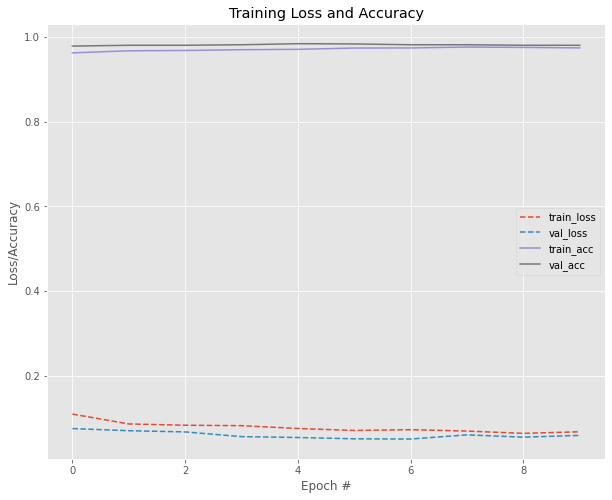

In [ ]:
# plot the training loss and accuracy
plt.style.use("ggplot")
fig, ax = plt.subplots(1,1,figsize=(10,8))

ax.plot(np.arange(0, 10), history.history["loss"], label="train_loss",linestyle='--')
ax.plot(np.arange(0, 10), history.history["val_loss"], label="val_loss",linestyle='--')
ax.plot(np.arange(0, 10), history.history["accuracy"], label="train_acc")
ax.plot(np.arange(0, 10), history.history["val_accuracy"], label="val_acc")
ax.set_title("Training Loss and Accuracy")
ax.set_xlabel("Epoch #")
ax.set_ylabel("Loss/Accuracy")
ax.legend()
plt.show()

In [ ]:
print("[INFO] {} kWh of electricity used since the begining".format(tracker_1.final_emissions_data.energy_consumed + 
                                                                    tracker_2.final_emissions_data.energy_consumed))

print("[INFO] Energy consumed for RAM: {} kWh".format(tracker_1.final_emissions_data.ram_energy + 
                                                      tracker_2.final_emissions_data.ram_energy))

print("[INFO] Energy consumed for all GPU: {} kWh".format(tracker_1.final_emissions_data.gpu_energy
                                                          + tracker_2.final_emissions_data.gpu_energy))

print("[INFO] Energy consumed for all CPU: {} kWh".format(tracker_1.final_emissions_data.cpu_energy + 
                                                          tracker_2.final_emissions_data.cpu_energy))

print("[INFO] CO2 emission {}(in Kg)".format(tracker_1.final_emissions_data.emissions 
                                             + tracker_2.final_emissions_data.emissions))

[INFO] 0.011534928174678926 kWh of electricity used since the begining
[INFO] Energy consumed for RAM: 0.0005545957412253254 kWh
[INFO] Energy consumed for all GPU: 0.006019579800901877 kWh
[INFO] Energy consumed for all CPU: 0.004960752632551723 kWh
[INFO] CO2 emission 0.001600469250071381(in Kg)


In [ ]:
images, labels = tuple(zip(*test_dataset))
images = np.concatenate(images,axis=0)
labels = np.concatenate(labels,axis=0)

In [ ]:
# evaluate the network
print("[INFO] evaluating network...")
predictions = ft_mobileNet_model.predict(images, batch_size=32)
print(classification_report(tf.argmax(labels, axis=1),
                            tf.argmax(predictions, axis=1),
                            target_names=class_names))

[INFO] evaluating network...
12/12 [==============================] - 1s 41ms/step
              precision    recall  f1-score   support

        Fire       0.99      0.97      0.98       193
    Non-Fire       0.97      0.99      0.98       191

    accuracy                           0.98       384
   macro avg       0.98      0.98      0.98       384
weighted avg       0.98      0.98      0.98       384



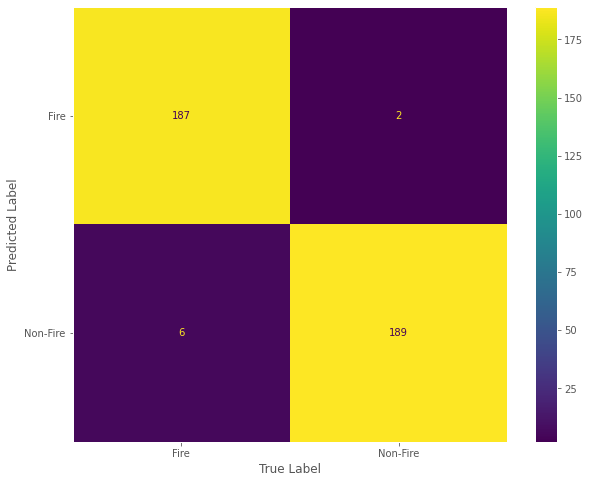

In [ ]:
fig_confusion_matrix, ax = plt.subplots(1,1,figsize=(10,8))
ConfusionMatrixDisplay(confusion_matrix(tf.argmax(predictions, axis=1),
                                        tf.argmax(labels, axis=1)),
                       display_labels=class_names).plot(values_format=".0f",ax=ax)

ax.set_xlabel("True Label")
ax.set_ylabel("Predicted Label")
ax.grid(False)
plt.show()

In [ ]:
# Evaluation Metrics
logger.info("Validation Evaluation metrics")
fbeta = fbeta_score(labels.argmax(axis=1), 
                    predictions.argmax(axis=1), 
                    beta=1, zero_division=1,average='weighted')

precision = precision_score(labels.argmax(axis=1),
                            predictions.argmax(axis=1),
                            zero_division=1,average='weighted')

recall = recall_score(labels.argmax(axis=1),
                      predictions.argmax(axis=1),
                      zero_division=1,average='weighted')

acc = accuracy_score(labels.argmax(axis=1),
                     predictions.argmax(axis=1))

logger.info("Validation Accuracy: {}".format(acc))
logger.info("Validation Precision: {}".format(precision))
logger.info("Validation Recall: {}".format(recall))
logger.info("Validation F1: {}".format(fbeta))

run.summary["Acc"] = acc
run.summary["Precision"] = precision
run.summary["Recall"] = recall
run.summary["F1"] = fbeta

run.summary["Count_Params"] = ft_mobileNet_model.count_params()

run.summary["Energy_Consumed"] = tracker.final_emissions_data.energy_consumed
run.summary["Energy_RAM"] = tracker.final_emissions_data.ram_energy
run.summary["Energy_GPU"] = tracker.final_emissions_data.gpu_energy
run.summary["Energy_CPU"] = tracker.final_emissions_data.cpu_energy

run.summary["CO2_Emissions"] = tracker.final_emissions_data.emissions

30-11-2022 01:12:31 Validation Evaluation metrics
30-11-2022 01:12:31 Validation Accuracy: 0.9791666666666666
30-11-2022 01:12:31 Validation Precision: 0.9793769502102835
30-11-2022 01:12:31 Validation Recall: 0.9791666666666666
30-11-2022 01:12:31 Validation F1: 0.9791655363553337


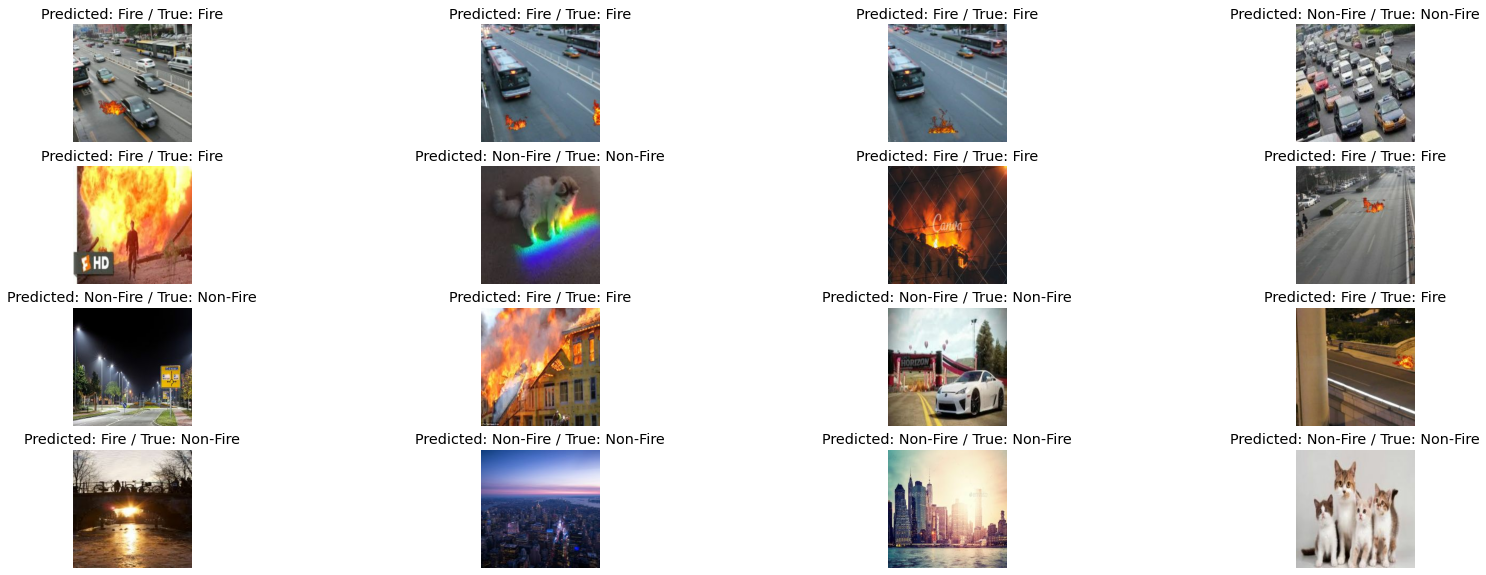

In [ ]:
plt.figure(figsize=(28,10))
for i in range(16):
  ax = plt.subplot(4, 4, i + 1)
  true = tf.argmax(labels, axis=1).numpy().astype('uint8')[i]
  pred = tf.argmax(predictions, axis=1).numpy().astype('uint8')[i]
  plt.imshow(images[i].astype('uint8'))
  plt.title("Predicted: {} / True: {}".format(class_names[pred], class_names[true]))
  plt.axis("off")

In [ ]:
run.finish()

Acc,0.97917
CO2_Emissions,0.00214
Count_Params,16074690
Energy_CPU,0.0067
Energy_Consumed,0.01539
Energy_GPU,0.00795
Energy_RAM,0.00075
F1,0.97917
Precision,0.97938
Recall,0.97917
